<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

# <center> Проект: Анализ вакансий из HeadHunter
   

In [479]:
#Подразумевается, что все необходимые бибилотеки установлены, но при необходимости их можно инсталлировать командой (предварительно убрав с нее комментарий):
#!pip install -r requirements.txt

In [480]:
# Импорт основных библиотек для работы с БД и данными
import psycopg2   
import pandas as pd

# Для "красоты" убираем предупреждения и засекаем время работы ВСЕЙ программы
import warnings
warnings.filterwarnings('ignore')

import time
start_time = time.time()

In [481]:
# вставьте сюда параметры подключения из юнита 1. Работа с базой данных из Python 
"""
впомогательная функция (выполнена для закрепления навыков программирования на Python) для
формирования переменных доступа к БД (сервер,логин,пароль и т.д.), сохраненных в файле 'db_config.txt'

пример файл 'db_config.txt' (фактически можно выполнить Copy & Paste из описания к заданию):

DBNAME = 'project_sql'
USER = 'skillfactory'
PASSWORD = 'real_password'
HOST = '84.201.134.129'
PORT = 5432

"""
def load_db_config():
    result = dict()
    with open('db_config.txt', 'r') as db_config:
        lines = db_config.readlines()
        for line in lines:
            line = line.replace("'", "").strip()
            key_val = line.split('=')
            result[key_val[0].strip()] = key_val[1].strip()
    return result['DBNAME'], result['USER'], result['HOST'], result['PASSWORD'], result['PORT']

# сохраняем конф. данные соедения к БД в соот. переменные
DBNAME, USER, HOST, PASSWORD, PORT = load_db_config()

"""
вспомогательная функция, которая:
- открывает соединение с БД
- с помощью Pandas загружает данные в результирующий DataFrame, "описанные" в строке запроса SQL
- закрывает соединение с БД
- по умолчанию(можно отключить) выводит результирующий DataFrame на экран
- возвращает результат в виде DataFrame
"""
def load_and_show_data(sql_query, show_result=True, show_index=False, title_of_result='Результат запроса:'):
    with psycopg2.connect(
        dbname=DBNAME,
        user=USER,
        host=HOST,
        password=PASSWORD,
        port=PORT
    ) as conn:
        result = pd.read_sql_query(sql_query, conn)
    conn.close()
    if show_result:
        print(title_of_result)
        print(result.to_string(index=show_index))
    return result

# Юнит 3. Предварительный анализ данных

1. Напишите запрос, который посчитает количество вакансий в нашей базе (вакансии находятся в таблице vacancies). 

In [482]:
# Обобщеный комментарий для запросов SQL Юнита 3
# SELECT Count(*) - запрос количества записей
# FROM  - выборка из требуемой таблицы

load_and_show_data(f'''
   SELECT Count(*) AS vacancies_count
   FROM vacancies
''');

Результат запроса:
 vacancies_count
           49197


2. Напишите запрос, который посчитает количество работодателей (таблица employers). 

In [483]:
load_and_show_data(f'''
    SELECT Count(*) AS employers_count
    FROM employers
''');

Результат запроса:
 employers_count
           23501


3. Посчитате с помощью запроса количество регионов (таблица areas).

In [484]:
load_and_show_data(f'''
    SELECT Count(*) AS areas_count
    FROM areas
''');

Результат запроса:
 areas_count
        1362


4. Посчитате с помощью запроса количество сфер деятельности в базе (таблица industries).

In [485]:
load_and_show_data(f'''
    SELECT Count(*) AS industries_count
    FROM industries
''');

Результат запроса:
 industries_count
              294


***

### Юнит 3: Выводы по предварительному анализу данных

**Итого:**
- Всего вакансии: 49197 
- Всего работодателей: 23501
- Всего регионов(населенных пунктов): 1362
- Всего сфер деятельности: 294

Предварительно, зная только эту информацию и учитывая связи между данными, можно определенно утвреждать, что:
- в среднем(минимум один) работодатель  предлагает **2** вакансий (49197 / 23501)
- в среднем(минимум в одном) в регионе  предлагается **36** вакансий (49197 / 1362)
- в среднем(минимум от одной) от каждой индустрии(сферы деятельности) предлагается **167** вакансий (49197 / 294)

- в среднем(минимум в одном) регионе находится **17** работодателей (23501 / 1362)
- в среднем(минимум одна) каждая индустрия представлена **79** компанией (работодателем) (23501 / 294)

P.S.: в скобках есть оговорка (минимум ...), это означает, что может быть(и он наверняка есть) "перекос", т.е. когда, например, одна компания предлагает почти все вакансии, а каждая оставшаяся только по одной

# Юнит 4. Детальный анализ вакансий

1. Напишите запрос, который позволит узнать, сколько (cnt) вакансий в каждом регионе (area).
Отсортируйте по количеству вакансий в порядке убывания.

In [486]:
load_and_show_data(f'''
    SELECT a.name area_name, Count(*) AS vacancies_count
    FROM areas a
    JOIN  vacancies v ON a.id = v.area_id
    GROUP BY area_name
    ORDER BY vacancies_count DESC
    LIMIT 5
''', title_of_result='Топ-5 населенных пунктов по количеству вакансий');

Топ-5 населенных пунктов по количеству вакансий
      area_name  vacancies_count
         Москва             5333
Санкт-Петербург             2851
          Минск             2112
    Новосибирск             2006
         Алматы             1892


2. Напишите запрос, чтобы определить у какого количества вакансий заполнено хотя бы одно из двух полей с зарплатой.

In [487]:
load_and_show_data(f'''
    SELECT Count(*) AS not_empty_salary_count
    FROM vacancies
    WHERE salary_from IS NOT NULL OR
          salary_to   IS NOT NULL
''');

Результат запроса:
 not_empty_salary_count
                  24073


3. Найдите средние значения для нижней и верхней границы зарплатной вилки. Округлите значения до целого.

In [488]:
load_and_show_data(f'''
    SELECT Round(Avg(salary_from)) avg_salary_from,
           Round(Avg(salary_to)) avg_salary_to
    FROM vacancies
''');

Результат запроса:
 avg_salary_from  avg_salary_to
         71065.0       110537.0


4. Напишите запрос, который выведет количество вакансий для каждого сочетания типа рабочего графика (schedule) и типа трудоустройства (employment), используемого в вакансиях. Результат отсортируйте по убыванию количества.


In [489]:
load_and_show_data('''
    SELECT schedule, employment, Count(*) AS vacancies_count
    FROM vacancies
    GROUP BY schedule, employment
    ORDER BY vacancies_count DESC
''');

Результат запроса:
        schedule          employment  vacancies_count
     Полный день    Полная занятость            35367
Удаленная работа    Полная занятость             7802
   Гибкий график    Полная занятость             1593
Удаленная работа Частичная занятость             1312
  Сменный график    Полная занятость              940
     Полный день          Стажировка              569
  Вахтовый метод    Полная занятость              367
     Полный день Частичная занятость              347
   Гибкий график Частичная занятость              312
     Полный день    Проектная работа              141
Удаленная работа    Проектная работа              133
   Гибкий график          Стажировка              116
  Сменный график Частичная занятость              101
Удаленная работа          Стажировка               64
   Гибкий график    Проектная работа               18
  Сменный график          Стажировка               12
  Вахтовый метод    Проектная работа                2
  Сменный

5. Напишите запрос, выводящий значения поля Требуемый опыт работы (experience) в порядке возрастания количества вакансий, в которых указан данный вариант опыта. 

In [490]:
load_and_show_data(f'''
    SELECT experience, Count(*) AS vacancies_count
    FROM vacancies
    GROUP BY 1
    ORDER BY 2
''');

Результат запроса:
        experience  vacancies_count
       Более 6 лет             1337
         Нет опыта             7197
     От 3 до 6 лет            14511
От 1 года до 3 лет            26152


***

### Выводы по детальному анализу вакансий (Юнит 4)
1) Чем крупнее населенный пункт (площадь, население), тем больше вакансий предлагается в нем.
2) Почти у половины (24073) вакансий не указана одна из границ ЗП, возможно данные вакансии имеют определеную ставку(фиксированная ЗП, бюджет?).
3) Средне-максимальная ЗП выше средне-минимальной в полтора раза (110537.0 / 71065.0).
4) По распорядку и типу занятости явный лидер: "Полный день/Полная занятость", хотя на 'пятки уже наступает' "Удаленная работа" (пока в ~4.5 раза меньше). К сожалению в БД не фигурирует дата, очень бы хотелось увидеть зависимость(и рост/спад) между "удаленностью" и, возможно, ковидными огранчениями.
5) Среди кандидатов работодатель выбирает "золотую середину" - средне-минимальный опыт: от кандидата будет средний результат при возможно средней ЗП(?). Наверное имеет смысл посмотреть "Опыт" в разрезе "ЗП"

# Юнит 5. Анализ работодателей

1. Напишите запрос, который позволит узнать, какие работодатели находятся на первом и пятом месте по количеству вакансий.

In [492]:
load_and_show_data(f'''
(
    SELECT e.name company_name, Count(v.id) company_vacancies
    FROM employers e
    JOIN vacancies v ON e.id = v.employer_id
    GROUP BY company_name
    ORDER BY company_vacancies DESC
    LIMIT 5
)
''', show_index=True);

Результат запроса:
    company_name  company_vacancies
0         Яндекс               1933
1     Ростелеком                491
2       Тинькофф                444
3           СБЕР                428
4  Газпром нефть                331


2. Напишите запрос, который для каждого региона выведет количество работодателей и вакансий в нём.
Среди регионов, в которых нет вакансий, найдите тот, в котором наибольшее количество работодателей.


In [494]:
load_and_show_data(f'''
    SELECT a.name, Count(e.id) AS employers_cnt, Count(v.id) AS vacancies_count
    FROM areas a 
    JOIN employers e ON a.id = e.area
    LEFT JOIN vacancies v ON a.id = v.area_id
    WHERE v.id IS NULL
    GROUP BY 1
    ORDER BY 3, 2 DESC
    LIMIT 10
''');

Результат запроса:
                 name  employers_cnt  vacancies_count
               Россия            410                0
            Казахстан            207                0
   Московская область             75                0
   Краснодарский край             19                0
   Ростовская область             18                0
             Беларусь             18                0
          Азербайджан             17                0
Нижегородская область             16                0
 Республика Татарстан             16                0
           Узбекистан             15                0


3. Для каждого работодателя посчитайте количество регионов, в которых он публикует свои вакансии. Отсортируйте результат по убыванию количества.


In [496]:
load_and_show_data(f'''
    SELECT e.name employer_name, Count(DISTINCT area_id) AS area_count
    FROM vacancies v
    JOIN employers e ON v.employer_id = e.id
    GROUP BY employer_name
    ORDER BY area_count DESC
    LIMIT 10
''');

Результат запроса:
             employer_name  area_count
                    Яндекс         181
                Ростелеком         152
                Спецремонт         116
    Поляков Денис Иванович          88
                 ООО ЕФИН           71
                Совкомбанк          63
                       МТС          55
ЭФКО, Управляющая компания          49
              Почта России          48
                      КРОН          48


4. Напишите запрос для подсчёта количества работодателей, у которых не указана сфера деятельности. 

In [498]:
load_and_show_data(f'''
    SELECT Count(*) AS employers_without_industries_count
    FROM employers e
    LEFT JOIN employers_industries ei ON e.id = ei.employer_id
    WHERE ei.employer_id IS NULL
''');

Результат запроса:
 employers_without_industries_count
                               8419


5. Напишите запрос, чтобы узнать название компании, находящейся на третьем месте в алфавитном списке (по названию) компаний, у которых указано четыре сферы деятельности. 

In [509]:
load_and_show_data(f'''
    SELECT e.name
    FROM employers e
    JOIN employers_industries ei ON e.id = ei.employer_id
    GROUP BY e.name
    HAVING Count(distinct ei.industry_id) = 4
    ORDER BY e.name
    LIMIT 3
''');

Результат запроса:
        name
101 Интернет
    21vek.by
        2ГИС


6. С помощью запроса выясните, у какого количества работодателей в качестве сферы деятельности указана Разработка программного обеспечения.


In [422]:
# Запрос для быстрого ответа на задание
load_and_show_data(f'''
    SELECT Count(DISTINCT ei.employer_id) AS emp_dev_po
    FROM employers_industries ei
    JOIN industries i ON ei.industry_id = i.id
    WHERE i.name = 'Разработка программного обеспечения'
''');

print()

# Запрос для краткого анализа (вывод)
load_and_show_data(f'''
    SELECT Substring(i.name, 0, 50) short_name_industry, Count(DISTINCT ei.employer_id) AS emp_dev_po
    FROM employers_industries ei
    JOIN industries i ON ei.industry_id = i.id
    GROUP BY short_name_industry
    ORDER BY emp_dev_po DESC
    LIMIT 10
''', title_of_result='Результат для выводов Юнита 5:', show_index=True);

# Запрос для сохранения полного результата (возможно пригодится в будущем)
results['5.5'] = load_and_show_data(f'''
    SELECT Substring(i.name, 0, 50) short_name_industry, Count(DISTINCT ei.employer_id) AS emp_dev_po
    FROM employers_industries ei
    JOIN industries i ON ei.industry_id = i.id
    GROUP BY short_name_industry
    ORDER BY emp_dev_po DESC
''', show_result=False);

Результат запроса:
 emp_dev_po
       3553

Результат для выводов Юнита 5:
                                 short_name_industry  emp_dev_po
0                Разработка программного обеспечения        3553
1  Системная интеграция,  автоматизации технологичес        2993
2  Интернет-компания (поисковики, платежные системы,        1675
3  Маркетинговые, рекламные, BTL, дизайнерские, Even         798
4                              Консалтинговые услуги         662
5  Электронно-вычислительная, оптическая, контрольно         629
6  Промышленное, бытовое электрооборудование и элект         507
7                                 Кадровые агентства         389
8                       Розничная сеть (продуктовая)         368
9                                   Интернет-магазин         351


7. Для компании «Яндекс» выведите список регионов-миллионников, в которых представлены вакансии компании, вместе с количеством вакансий в этих регионах. Также добавьте строку Total с общим количеством вакансий компании. Результат отсортируйте по возрастанию количества.

Список городов-милионников надо взять [отсюда](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8). 

Если возникнут трудности с этим задание посмотрите материалы модуля  PYTHON-17. Как получать данные из веб-источников и API. 

In [423]:
# код для получения списка городов-милионников, выполнен для закрепления навыков программировая на Python

# импортируем нужные библиотеки для загрузки данных из "Сети" и их(данных) парсинга
from bs4 import BeautifulSoup
import requests

# используя "постоянную" ссылка, загружаем данные по консантрой ссылке
url = 'https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8'
text = requests.get(url).text

# начинаем "искать" нужные данные на HTML-странице
# предварительный анализ (исходный код страницы), показал, что список нужных нам городов находится во второй ячейке TD, таблицы, находящейся за родителем "заголовка" <SPAN>
# Краткий алгоримт следующего кода:
# - находим <SPAN> с нужным ID
# - переходим к родителя с сразу возвращаем следующего "брата"
# - проверяем таблица ли это, иначе переходим к следующему "брату", и так, пока не найдем таблицу
# - возвращаем все записи в найденной таблице
# - определяем переменную для результата
# - перебираем все записи в таблице
# - если, ячеек больше чем одна, то скорее всего это запись с названием города
# - забираем название города (в результат), предварительно очистим от "лишних" символов
# - выводим промежуточный вывод
table_with_cities = BeautifulSoup(text, 'html.parser').find('span', id='Список_городов-миллионеров')
table_with_cities = table_with_cities.parent.next_sibling

while table_with_cities.name != 'table':
    table_with_cities = table_with_cities.next_sibling

table_with_cities_trs = table_with_cities.find('tbody').find_all('tr')

million_cities = []
for row in table_with_cities_trs:
    tds = row.find_all('td')
    if len(tds) > 1:
        million_cities.append(tds[1].text.strip().replace('[a]', ''))

print('Из "википедии" с помощью библиотек "requests" и "BeautifulSoup". найдены следующие города-миллионнеры (всего-{}):'.format(len(million_cities)))
print(*million_cities, sep=', ')

Из "википедии" с помощью библиотек "requests" и "BeautifulSoup". найдены следующие города-миллионнеры (всего-16):
Москва, Санкт-Петербург, Новосибирск, Екатеринбург, Казань, Нижний Новгород, Челябинск, Красноярск, Самара, Уфа, Ростов-на-Дону, Омск, Краснодар, Воронеж, Пермь, Волгоград


In [424]:
# предварительно формируем строки для запроса в формате SQL названия города и искомую компанию
where_million_cities = "'" + "','".join(million_cities) + "'"
where_company_name = "'Яндекс'"

# Запрос для быстрого ответа на задание и для сохранения полного результата (возможно пригодится в будущем)
results['5.5'] = load_and_show_data(f'''
(
	SELECT a.name AS name, Count(*) AS cnt
	FROM areas a
	JOIN vacancies v ON a.id = v.area_id
	JOIN employers e ON e.id = v.employer_id
	WHERE a.name IN ({where_million_cities}) AND e.name = {where_company_name}
	GROUP BY a.name
)
UNION
(
	SELECT 'Total' AS name, Count(*) cnt
	FROM areas a
	JOIN vacancies v ON a.id = v.area_id
	JOIN employers e ON e.id = v.employer_id
	WHERE a.name IN ({where_million_cities}) AND e.name = {where_company_name}
)
ORDER BY cnt, name
''', show_index=True);

Результат запроса:
               name  cnt
0              Омск   21
1         Челябинск   22
2        Красноярск   23
3         Волгоград   24
4            Казань   25
5             Пермь   25
6    Ростов-на-Дону   25
7            Самара   26
8               Уфа   26
9         Краснодар   30
10          Воронеж   32
11      Новосибирск   35
12  Нижний Новгород   36
13     Екатеринбург   39
14  Санкт-Петербург   42
15           Москва   54
16            Total  485


***

### Выводы по анализу работодателей (Юнит 5)
1) Больше всех вакансии (почти в 4 раза от "второго" места) предлагает компания Яндекс, далее в ТОП-25 (с количеством предлагаемых вакансий от 100), входят довольно крупные компании (ИТ, Банки, Связь, Нефть), которым постоянно требуется новые кадры: развитие, возможная "текучка кадров", расширение бизнеса  и т.д.

2) Учитывая регионы в которых не предлагается вакансий, можно выявить следующую закономерность: чем крупнее(обширнее) область (страна, регион/республика, город), тем больше в ней компаний у которых нет вакансий. Скорее всего это связано с небольшими компаниями, которые обобщенно указывали наиболее крупный регион (возможно требовалось для регистрации на HH) и предлагали удаленную работу. После закрытия вакансии, информации об компании оставалась в БД HH, при этом вакансия уже "не видна" и так и образовались работодатели "без вакансии".

3) Наибольшее количество регионов у "троицы": Яндекс, Ростелеком, Спецремонт, это может быть связано с широкой сетью офисов(предоставления услуг) по регионам, что точно характерно для Ростелекома. Также возможно идет "сбор специалистов по регионом" с возможной удаленной работой или предложением постоянной релокации в ближайший офис компании

4) Очень странно видеть такое количество (8419 / 23501, больше трети) работодателей у которых не указана сфера деятельности, наверняка можно выбрать из 294 или дать какое-то обобщенное название.

5) Наиболее часто (мода, медианна) компании указывают 1-2 сферы деятельности, что характерно, очень редко - от 6 и более.

6) Фактически весь TOP-10 (за исключением "Розничная сеть (продуктовая)") сгруппированных компаний и отсортированных(убывание) по сфере деятельности, представляют компании, связанные с IT. Таким компаниям совсем не сложно искать новые кадрые через Интернет.

7) Компания "Яндекс" представлена(предлагает вакансии) в каждом из регионов-миллионников, практически пропорционально (кол-во вакансий) населению этого региона.

# Юнит 6. Предметный анализ

1. Сколько вакансий имеет отношение к данным?

Считаем, что вакансия имеет отношение к данным, если в её названии содержатся слова 'data' или 'данн'.

*Подсказка: Обратите внимание, что названия вакансий могут быть написаны в любом регистре.* 


In [425]:
load_and_show_data(f'''
    SELECT Count(*) AS ds_count
    FROM vacancies
    WHERE Lower(name) LIKE '%data%' OR Lower(name) LIKE '%данн%'
''');

Результат запроса:
 ds_count
     1771


2. Сколько есть подходящих вакансий для начинающего дата-сайентиста? 
Будем считать вакансиями для дата-сайентистов такие, в названии которых есть хотя бы одно из следующих сочетаний:
* 'data scientist'
* 'data science'
* 'исследователь данных'
* 'ML' (здесь не нужно брать вакансии по HTML)
* 'machine learning'
* 'машинн%обучен%'

** В следующих заданиях мы продолжим работать с вакансиями по этому условию.*

Считаем вакансиями для специалистов уровня Junior следующие:
* в названии есть слово 'junior' *или*
* требуемый опыт — Нет опыта *или*
* тип трудоустройства — Стажировка.
 

In [521]:
# Под-условия для поиска вакансии дата-сайентиста
data_sience_where = '''(
        Lower(name) LIKE '%data scientist%'
        OR Lower(name) LIKE '%data science%'
        OR Lower(name) LIKE '%исследователь данных%'
        OR Lower(name) LIKE '%machine learning%'
        OR Lower(name) LIKE '%машинн%обучен%%'
        OR (
            name LIKE '%ML%'
            AND name NOT LIKE '%HTML%'
        )
)'''

load_and_show_data(f'''
    SELECT Count(*) AS junior_cnt
    FROM vacancies
    WHERE {data_sience_where}
        AND (
            Lower(name) LIKE '%junior%'
            OR experience = 'Нет опыта'
            OR employment = 'Стажировка'
        )
''');

Результат запроса:
 junior_cnt
         51


3. Сколько есть вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres?

** Критерии для отнесения вакансии к DS указаны в предыдущем задании.*

In [522]:
load_and_show_data(f'''
    SELECT Count(*) AS ds_and_db_cnt
    FROM vacancies
    WHERE {data_sience_where}
        AND (
            Upper(key_skills) LIKE '%SQL%'
            OR Lower(key_skills) LIKE '%postgres%'
        )
''');

Результат запроса:
 ds_and_db_cnt
           201


4. Проверьте, насколько популярен Python в требованиях работодателей к DS.Для этого вычислите количество вакансий, в которых в качестве ключевого навыка указан Python.

** Это можно сделать помощью запроса, аналогичного предыдущему.*

In [523]:
load_and_show_data(f'''
    SELECT count(*) ds_and_python_cnt
    FROM vacancies
    WHERE {data_sience_where}
        AND  Lower(key_skills) LIKE '%python%'
''');

Результат запроса:
 ds_and_python_cnt
               351


5. Сколько ключевых навыков в среднем указывают в вакансиях для DS?
Ответ округлите до двух знаков после точки-разделителя.

In [524]:
load_and_show_data(f'''
    SELECT Round(
                Avg(
                    1 + length(key_skills) - length(replace(key_skills, chr(9), ''))  
                )
            , 2) AS ds_key_skills_cnt
    FROM vacancies
    WHERE {data_sience_where}
        AND  key_skills IS NOT NULL
''');

Результат запроса:
 ds_key_skills_cnt
              6.41


6. Напишите запрос, позволяющий вычислить, какую зарплату для DS в **среднем** указывают для каждого типа требуемого опыта (уникальное значение из поля *experience*). 

При решении задачи примите во внимание следующее:
1. Рассматриваем только вакансии, у которых заполнено хотя бы одно из двух полей с зарплатой.
2. Если заполнены оба поля с зарплатой, то считаем зарплату по каждой вакансии как сумму двух полей, делённую на 2. Если заполнено только одно из полей, то его и считаем зарплатой по вакансии.
3. Если в расчётах участвует null, в результате он тоже даст null (посмотрите, что возвращает запрос select 1 + null). Чтобы избежать этой ситуацию, мы воспользуемся функцией [coalesce](https://postgrespro.ru/docs/postgresql/9.5/functions-conditional#functions-coalesce-nvl-ifnull), которая заменит null на значение, которое мы передадим. Например, посмотрите, что возвращает запрос `select 1 + coalesce(null, 0)`

Выясните, на какую зарплату в среднем может рассчитывать дата-сайентист с опытом работы от 3 до 6 лет. Результат округлите до целого числа. 

In [527]:
load_and_show_data(f'''
    SELECT  Round(
                Avg(
                    (Coalesce(salary_from, salary_to) + Coalesce(salary_to, salary_from)) / 2
                )
            ) AS ds_avg_salary
    FROM vacancies
    WHERE  experience = 'От 3 до 6 лет'
         AND (
                salary_to   IS NOT NULL
                OR salary_from IS NOT NULL
            )
        AND {data_sience_where}       
''');

Результат запроса:
 ds_avg_salary
      243115.0


***

### Выводы по предметному анализу(DataSience) (Юнит 6)

1) Вакансии конкретно для DataSience занимают примерно 3.6% (1771 / 49197 * 100) от общего числа вакансий, что в общем-то не мало.
2) Среди представленных вакансий найдется место и юниорам 2.9% (51 / 1771 * 100)
3) Впечатлила ЗП (см. график), новая профессия выбрана не зря.

# Общий вывод по проекту

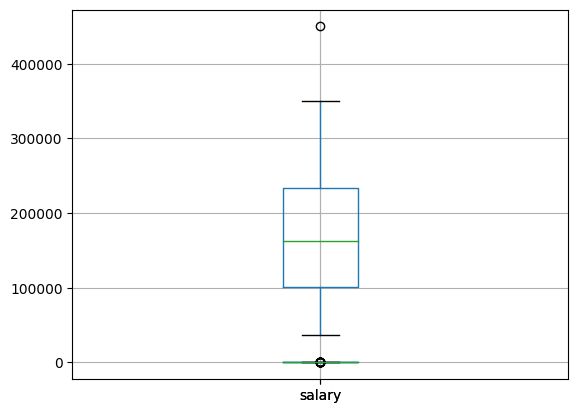

In [528]:
# подведем итог исследования, обобщите выводы
# здесь можно (это будет плюсом) провести дополнительные исследования данных, сделать прогнозы, продумать варианты продолжения исследования


# Дополнительные исследования по 5.4
load_and_show_data(f'''
    SELECT name AS vacancy_name, Count(*) AS cnt
    FROM vacancies
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 50
''', title_of_result='Топ-50 вакансий (по названию):'
,show_result=False);


load_and_show_data(f'''
    SELECT e.name, Count(DISTINCT ei.industry_id) AS industry_count
    FROM employers e
    JOIN employers_industries ei ON e.id = ei.employer_id
    GROUP BY e.name
    ORDER BY industry_count DESC
''',show_result=False).boxplot('industry_count');

load_and_show_data(f'''
    SELECT  (Coalesce(salary_from, salary_to) + Coalesce(salary_to, salary_from)) / 2 AS salary
    FROM vacancies
    WHERE  (
            salary_to   IS NOT NULL OR
            salary_from IS NOT NULL
        ) AND {data_sience_where}
''', show_result=False).boxplot();

In [432]:
end_time = time.time()
run_time = round(end_time - start_time, 2)
print('Общее время работы "ПРОГРАММЫ" (при условии запуска "Run All"): {} сек., {}'.format(
    run_time,
    "что очень даже неплохо." if run_time < 10 else "ну, так-себе, нормально")
    )

Общее время работы "ПРОГРАММЫ" (при условии запуска "Run All"): 5.71 сек., что очень даже неплохо.
